In [2]:
import pandas as pd
import numpy as np
import os
import zipfile
from tools import *
from CONSTANT import *

signals = ['BVP', 'EDA', 'HR', 'TEMP']
# sample_rate = {'EDA': 4, 'BVP': 64, 'TEMP': 4, 'HR': 1}

In [5]:
wesad_path = r'./WESAD/WESAD/'
ppg_path = r'./PPGFieldStudyDataset/PPG_FieldStudy/'

In [3]:
def extract_E4zip(folderpath):
    for root, dir, files in os.walk(folderpath):
        for file in files:
            if '.zip' not in file and 'E4' not in file:
                continue
            filename = os.path.join(root, file)
            with zipfile.ZipFile(filename,"r") as zip_ref:
                zip_ref.extractall(filename.replace('.zip',''))
    print(filename, 'done')

In [6]:
# extract_E4zip(wesad_path)
# extract_E4zip(ppg_path)

# get label

In [3]:
# label_file = r'./WESAD/WESAD/S10/S10_quest.csv'

def get_label(quest_file):
    labels = pd.read_csv(quest_file)
    conditions = labels.loc[0].values[0].replace('# ORDER;', '').replace(';bRead;fRead;sRead;;;;;;;;;;;;;;;;;;', '').split(';')
    starts = [float(t) * 60 for t in labels.iloc[1].values[0].split(';')[1:6]]
    ends = [float(t) * 60 for t in labels.iloc[2].values[0].split(';')[1:6]]
    va = [sc[0].replace('# DIM;', '')[:3].split(';') for sc in labels.iloc[16: 21].values]
    valence = [float(sc[0]) for sc in va]
    arousal = [float(sc[1]) for sc in va]
    return conditions, starts, ends, valence, arousal


In [6]:
subjects = ['S6', 'S9', 'S2', 'S13', 'S11', 'S10', 'S8', 'S14',
            'S15', 'S5', 'S17', 'S16', 'S3', 'S7', 'S4']

valences = []
arousals = []

for subject in subjects:
    quest_file = os.path.join(wesad_path, subject, '{}_quest.csv'.format(subject))
    conditions, starts, ends, valence, arousal = get_label(quest_file)
    e4_path = os.path.join(wesad_path, subject, '{}_E4_Data'.format(subject))
    valences.extend(valence)
    arousals.extend(arousal)

In [50]:
win_size, step = 4, 2

signals = ['HR']

sub_df = []
for signal_name in signals:
    signal_df = []
    raw_signal = pd.read_csv(os.path.join(e4_path, '{}.csv'.format(signal_name))).iloc[2:, 0].values
    baseline = raw_signal[int(starts[0]*SAMPLERATE[signal_name]): int(ends[0]*SAMPLERATE[signal_name])+1].mean()
    for i in range(1, 5):
        condition_signal = raw_signal[int(starts[i]*SAMPLERATE[signal_name]): int(ends[i]*SAMPLERATE[signal_name])+1] - baseline
        signal = (condition_signal - condition_signal.min()) / (condition_signal.max() - condition_signal.min())
        condition = conditions[i]

        if signal_name == 'EDA':
            signal = butter_lowpass_filter(signal, cutOff=CUTOFF['EDA'], fs=SAMPLERATE['EDA'])
            signal = resample_by_interpolation(signal, input_fs=SAMPLERATE['EDA'], output_fs=100)
        elif signal_name in ['TEMP', 'BVP']:
            signal = butter_bandpass_filter(signal, lowcut=CUTOFF[signal_name][0], highcut=CUTOFF[signal_name][1], fs=SAMPLERATE[signal_name])
            signal = resample_by_interpolation(signal, input_fs=SAMPLERATE[signal_name], output_fs=100)
        elif signal_name == 'HR':
            # signal = chauvenet_filter(signal)
            # print(signal)
            signal = resample_by_interpolation(signal, input_fs=SAMPLERATE[signal_name], output_fs=100)
        else:
            pass

        segments = np.array(segment_generator(signal, win_size=win_size*100, step=step*100))
        seg_cols = ['{}_seg{}'.format(signal_name, i) for i in range(segments.shape[1])]
        segment_df = pd.DataFrame(columns=seg_cols, data=segments)

        segment_df['segment_id'] = segment_df.index.tolist()
        segment_df['condition'] = condition
        segment_df['valence_rating'] = valence[i]
        segment_df['arousal_rating'] = arousal[i]
        segment_df['participant_id'] = subject

        signal_df.append(segment_df)

    # pd.concat(signal_df)

# pd.concat(sub_df, axis=1)

In [51]:
pd.concat(signal_df)

,HR_seg0,HR_seg1,HR_seg2,HR_seg3,HR_seg4,HR_seg5,HR_seg6,HR_seg7,HR_seg8,HR_seg9,...,HR_seg395,HR_seg396,HR_seg397,HR_seg398,HR_seg399,segment_id,condition,valence_rating,arousal_rating,participant_id
0,0.578022,0.577912,0.577802,0.577692,0.577582,0.577473,0.577363,0.577253,0.577143,0.577033,...,0.538901,0.538813,0.538725,0.538637,0.538549,0,Fun,8.0,1.0,S4
1,0.556044,0.555956,0.555868,0.555780,0.555692,0.555604,0.555516,0.555429,0.555341,0.555253,...,0.522308,0.522242,0.522176,0.522110,0.522044,1,Fun,8.0,1.0,S4
2,0.538462,0.538363,0.538264,0.538165,0.538066,0.537967,0.537868,0.537769,0.537670,0.537571,...,0.527363,0.527385,0.527407,0.527429,0.527451,2,Fun,8.0,1.0,S4
3,0.521978,0.522011,0.522044,0.522077,0.522110,0.522143,0.522176,0.522209,0.522242,0.522275,...,0.527473,0.527473,0.527473,0.527473,0.527473,3,Fun,8.0,1.0,S4
4,0.527473,0.527473,0.527473,0.527473,0.527473,0.527473,0.527473,0.527473,0.527473,0.527473,...,0.532857,0.532879,0.532901,0.532923,0.532945,4,Fun,8.0,1.0,S4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.003209,0.003209,0.003209,0.003209,0.003209,0.003209,0.003209,0.003209,0.003209,0.003209,...,0.001243,0.001235,0.001227,0.001219,0.001211,203,Medi 2,5.0,2.0,S4
204,0.002407,0.002403,0.002399,0.002395,0.002391,0.002387,0.002383,0.002379,0.002375,0.002371,...,0.000020,0.000016,0.000012,0.000008,0.000004,204,Medi 2,5.0,2.0,S4
205,0.001203,0.001195,0.001187,0.001179,0.001171,0.001163,0.001155,0.001147,0.001139,0.001131,...,0.000401,0.000401,0.000401,0.000401,0.000401,205,Medi 2,5.0,2.0,S4
206,0.000000,0.000004,0.000008,0.000012,0.000016,0.000020,0.000024,0.000028,0.000032,0.000036,...,0.000401,0.000401,0.000401,0.000401,0.000401,206,Medi 2,5.0,2.0,S4


In [38]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# pd.set_option("display.max_info_columns", 1300)

import gc

%matplotlib inline

array([5.56666667, 4.89166667])

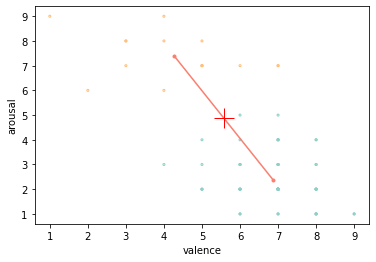

In [39]:
av_rating = pd.DataFrame()
av_rating['valence_rating'] = valences
av_rating['arousal_rating'] = arousals

colors = ["#8ECFC9", "#FF9C34", "#4E9A06"]

kmeans = KMeans(n_clusters=2, random_state=0).fit(av_rating[['valence_rating', 'arousal_rating']])
plt.scatter(y=av_rating['arousal_rating'], x=av_rating['valence_rating'], 
            facecolors='none', edgecolors=['#8ECFC9' if i==0 else '#FFBE7A' for i in kmeans.labels_ ], s=4)
plt.ylabel('arousal')
plt.xlabel('valence')
plt.plot(kmeans.cluster_centers_.T[0], kmeans.cluster_centers_.T[1], c='#FA7F6F', marker="o", markersize=3)
threshold = kmeans.cluster_centers_.sum(axis=0)/2
plt.plot(threshold[0], threshold[1], c='red', marker="+", markersize=20)
kmeans.cluster_centers_.sum(axis=0)/2

In [40]:
midpoint = kmeans.cluster_centers_.sum(axis=0)/2
av_rating['valence_label'] = av_rating['valence_rating'].apply(lambda x: 1 if x>midpoint[0] else 0)
av_rating['arousal_label'] = av_rating['arousal_rating'].apply(lambda x: 1 if x>midpoint[1] else 0)
av_rating.head()

,valence_rating,arousal_rating,valence_label,arousal_label
0,8.0,2.0,1,0
1,6.0,3.0,1,0
2,6.0,2.0,1,0
3,8.0,2.0,1,0
4,8.0,1.0,1,0


In [41]:
av_rating['valence_label'].value_counts()

1    57
0    18
Name: valence_label, dtype: int64

In [44]:
av_rating['valence_rating'].value_counts()

7.0    27
8.0    14
6.0    14
5.0     9
4.0     4
3.0     3
9.0     2
2.0     1
1.0     1
Name: valence_rating, dtype: int64

In [43]:
av_rating['arousal_label'].value_counts()

0    58
1    17
Name: arousal_label, dtype: int64

# get E4

In [13]:
eda_file = r'./WESAD/WESAD/S10/S10_E4_Data/EDA.csv'
eda = pd.read_csv(eda_file)

In [14]:
eda_raw_signal = eda.iloc[2:].values

In [15]:
len(eda_raw_signal)

27287

# parse pkl

In [6]:
pkl_path = r'./WESAD/WESAD/S10/S10.pkl'

with open(pkl_path, 'rb') as file:
    s10_data = pickle.load(file, encoding='latin1')

In [10]:
len(s10_data['label'])

3847200